# Прогнозирование временных рядов с использованием XGBoost


В этом блокноте мы рассмотрим прогнозирование временных рядов с помощью XGBoost. Мы будем использовать данные о почасовом потреблении энергии.

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor

# Данные
Мы будем использовать данные о почасовом потреблении энергии от компании PJM.

In [4]:
!gdown 1i2WS6RQo32syz1DUIPdo5bdaSM_XcJq_
!unzip train.zip
!cat train.csv | grep ",265559," > train2.csv && du -h train2.csv

Downloading...
From: https://drive.google.com/uc?id=1i2WS6RQo32syz1DUIPdo5bdaSM_XcJq_
To: /content/train.zip
100% 838M/838M [00:08<00:00, 93.7MB/s]
Archive:  train.zip
  inflating: train.csv               
3.2M	train2.csv


In [21]:
# pjme = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])
pjme = pd.read_csv('train2.csv', header=None) # считываем датасет
pjme.columns = (['id','date','store_nbr','item_nbr','unit_sales','onpromotion'])
pjme = pjme[['date','unit_sales']]
# pjme.reset_index(drop=True, inplace=True)
pjme.set_index('date', inplace=True)
pjme

,unit_sales
date,
2013-01-01,2.0
2013-01-02,36.0
2013-01-02,81.0
2013-01-02,86.0
2013-01-02,110.0
...,...
2017-08-15,40.0
2017-08-15,12.0
2017-08-15,20.0


In [15]:
pjme.head(1)

,date,unit_sales
0,2013-01-01,2.0


In [16]:
pjme.tail(1)

,date,unit_sales
83046,2017-08-15,10.0


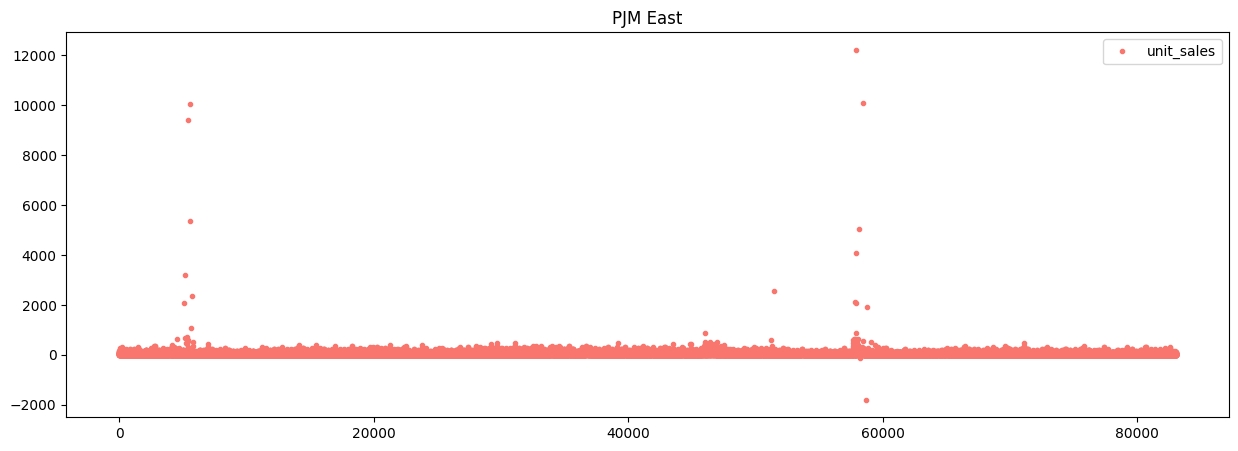

In [6]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

# Train / Test Split
Отрежем данные после 2015 года, чтобы использовать их в качестве набора для проверки.

In [25]:
split_date = '2017-01-01'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

<Axes: title={'center': 'test'}, xlabel='date'>

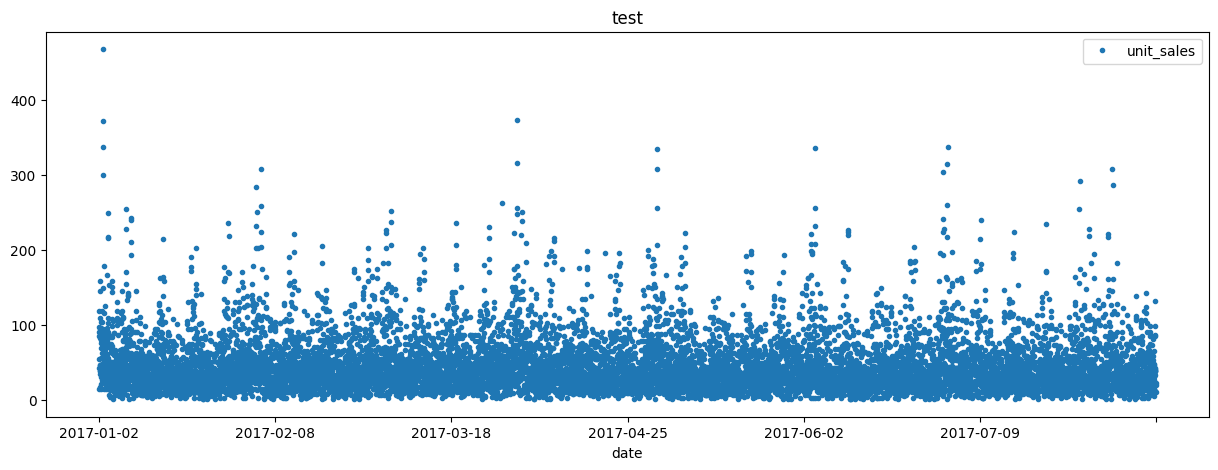

In [26]:
# _ = pjme_test \
#     .rename(columns={'PJME_MW': 'TEST SET'}) \
#     .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
#     .plot(figsize=(15,5), title='PJM East', style='.')
pjme_test.plot(figsize=(15,5), title='test', style='.')

# Создадим признаки

In [29]:
def create_features(df, label=None):
    """
    создаем признаки из datetime индекса
    """
    df['date'] = pd.to_datetime(df.index, errors='coerce') #df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [30]:
X_train, y_train = create_features(pjme_train, label='unit_sales')
X_test, y_test = create_features(pjme_test, label='unit_sales')

<ipython-input-29-8b9a1f043e0c>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-29-8b9a1f043e0c>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


# Создадим XGBoost Model

In [31]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Измените verbose на True, если хотите увидеть процесс обучения

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Важность признаков
Важность признаков - отличный способ получить общее представление о том, на какие признаки модель больше всего полагается при прогнозировании. Это показатель, который просто суммирует, сколько раз каждая функция была разделена. Можно посмотреть с помощью plot_importance


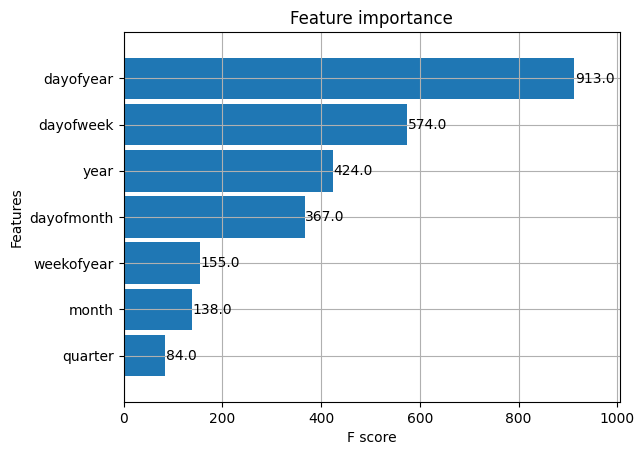

In [32]:
_ = plot_importance(reg, height=0.9)


Мы видим, что день года чаще всего использовался для разделения деревьев, а затем следуют час и год. Квартал имеет невысокую важность в связи с тем, что он мог быть создан разным разбиением по дням и годам.

# Предсказание на Test Set

In [33]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

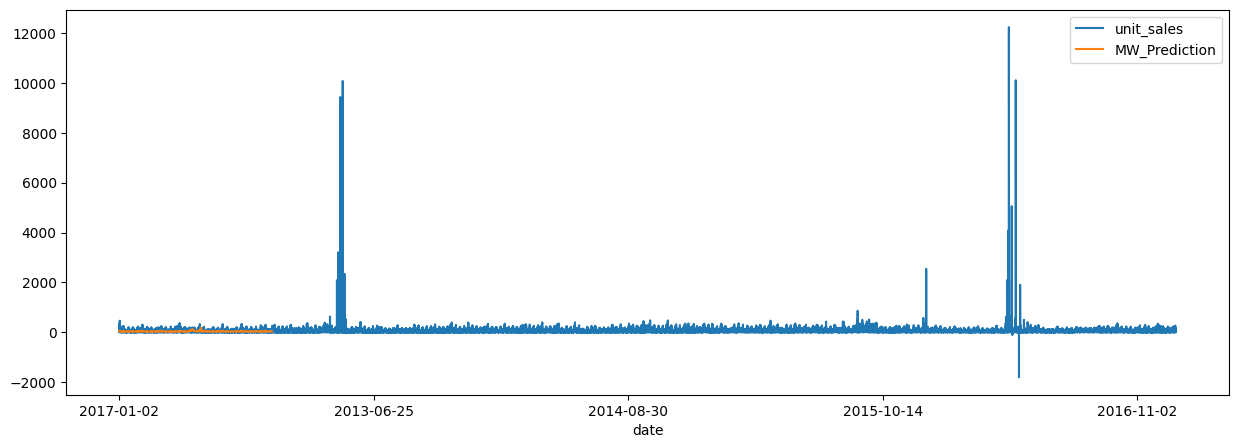

In [34]:
_ = pjme_all[['unit_sales','MW_Prediction']].plot(figsize=(15, 5))

# Посмотрим на первый месяц прогнозов

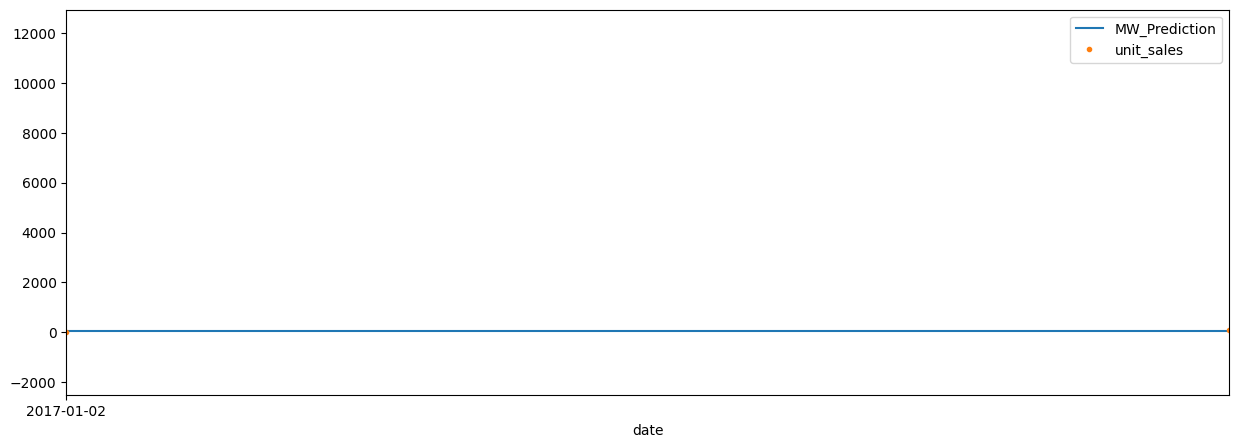

In [37]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','unit_sales']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2017-01-01', upper='2017-02-01')
# ax.set_ylim(0, 60000)
# plot = plt.suptitle('January 2015 Forecast vs Actuals')

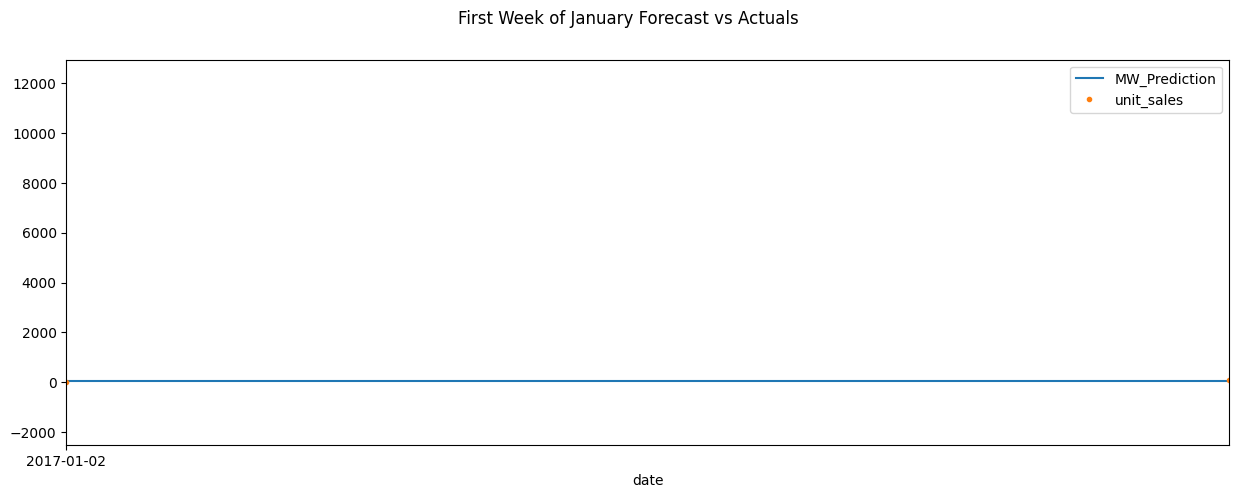

In [40]:
# Построим прогноз с фактическими данными
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','unit_sales']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2017-01-01', upper='2017-02-01')
# ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

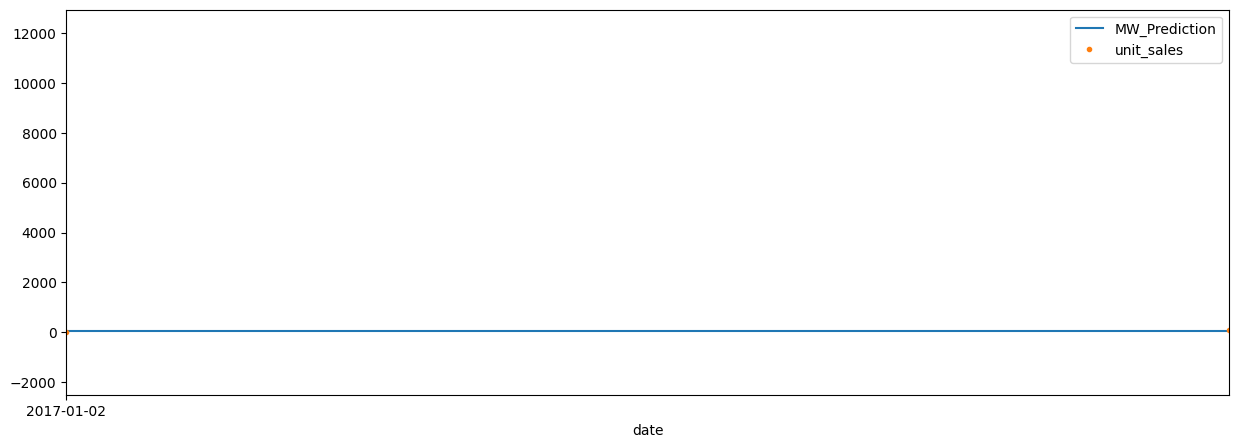

In [41]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','unit_sales']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_ylim(0, 60000)
ax.set_xbound(lower='2017-01-01', upper='2017-02-01')
# plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Ошибки на Test Set
 RMSE  is 13780445
 MAE  is 2848.89
 MAPE  is 8.9%

In [42]:
mean_squared_error(y_true=pjme_test['unit_sales'],
                   y_pred=pjme_test['MW_Prediction'])

1442.375275370523

In [43]:
mean_absolute_error(y_true=pjme_test['unit_sales'],
                   y_pred=pjme_test['MW_Prediction'])

25.00240080472289

Неплохо использовать средний абсолютный процент ошибки, потому что он дает легко интерпретируемый процент, показывающий, насколько ошибочны прогнозы.
MAPE не включен в sklearn, поэтому нам нужно использовать настраиваемую функцию.

In [44]:
def mean_absolute_percentage_error(y_true, y_pred):
    """считаем MAPE по y_true и y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [45]:
mean_absolute_percentage_error(y_true=pjme_test['unit_sales'],
                   y_pred=pjme_test['MW_Prediction'])

105.53128166739137

# Посмотрим на худшие и лучшие прогнозируемые дни

In [47]:
pjme_test['error'] = pjme_test['unit_sales'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['unit_sales','MW_Prediction','error','abs_error']]

<ipython-input-47-5af9ee71465b>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()[['unit_sales','MW_Prediction','error','abs_error']]


In [48]:
# За прогнозные дни
error_by_day.sort_values('error', ascending=True).head(10)

unit_sales  MW_Prediction       error   abs_error
year month dayofmonth                                                   
2017 5     3            48.094340     176.218552 -128.124212  128.124212
     4     21           38.111111     120.623734  -82.512622   84.156188
           19           33.528302     109.838127  -76.309825   76.309825
           20           37.722222     107.940765  -70.218543   73.479996
     5     9            37.188679      59.022278  -21.833599   30.429806
     4     24           40.094340      60.495964  -20.401624   27.101108
     5     2            54.730769      74.827766  -20.096997   34.624779
     4     17           40.509434      60.495964  -19.986530   27.384584
           25           39.132075      59.022278  -19.890202   29.013030
     5     8            40.905660      60.495964  -19.590304   30.478771


- Худший день №1 - 4 июля 2016 года - выходной.
- Худший день # 3 - 25 декабря 2015 - Рождество
- Худший день №5 - 4 июля 2016 года - выходной.

Похоже, наша модель может улучшиться после добавления индикатора праздника.

In [49]:
# Худшие абсолютные прогнозируемые дни
error_by_day.sort_values('abs_error', ascending=False).head(10)

unit_sales  MW_Prediction       error   abs_error
year month dayofmonth                                                   
2017 5     3            48.094340     176.218552 -128.124212  128.124212
     4     21           38.111111     120.623734  -82.512622   84.156188
           19           33.528302     109.838127  -76.309825   76.309825
           20           37.722222     107.940765  -70.218543   73.479996
           1           100.679245      58.957878   41.721367   55.280841
     1     2            90.188679      63.517319   26.671361   50.575145
     7     2            83.148148      62.870743   20.277409   49.041824
     5     1            82.703704      48.604733   34.098971   48.294544
     6     4            77.666667      65.230377   12.436289   45.190022
     1     7            60.132075      17.678658   42.453418   42.995203

Больше хорошо спрогнозируемых дней в октябре (не много праздников). Также ранний май.

In [50]:
# Лучшие прогнозируемые дни
error_by_day.sort_values('abs_error', ascending=True).head(10)

unit_sales  MW_Prediction     error  abs_error
year month dayofmonth                                                
2017 5     19           30.886792      29.358942  1.527850  12.599900
           11           28.754717      29.358942 -0.604225  13.125778
     1     26           29.679245      27.539169  2.140076  13.238066
     7     12           33.226415      32.199944  1.026472  13.615080
     5     18           29.388889      29.358940  0.029947  13.950135
     6     29           31.807692      29.358944  2.448750  13.958584
     1     19           27.320755      27.539169 -0.218415  14.154073
     7     13           28.307692      29.358944 -1.051250  14.299797
     5     25           25.634615      29.358944 -3.724327  14.374249
     1     27           30.566038      27.539169  3.026868  14.409356

# Построение лучших / худших прогнозируемых дней

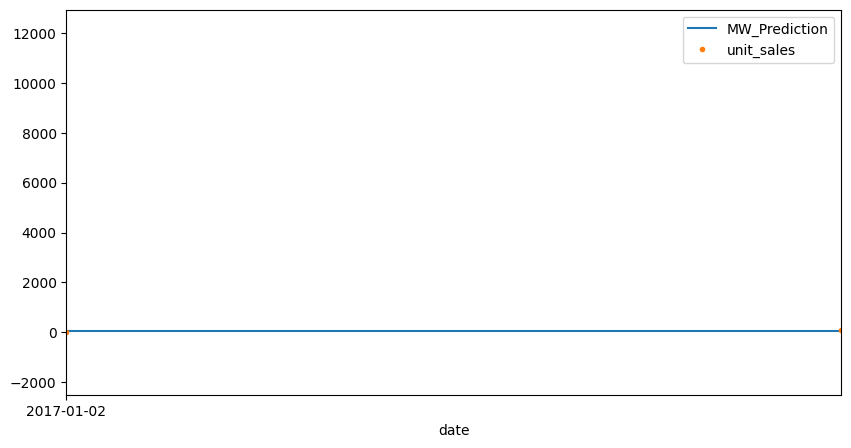

In [51]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','unit_sales']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_ylim(0, 60000)
ax.set_xbound(lower='2017-01-01', upper='2017-02-01')
# plot = plt.suptitle('Aug 13, 2016 - Дни с наихудшим предсказанием')

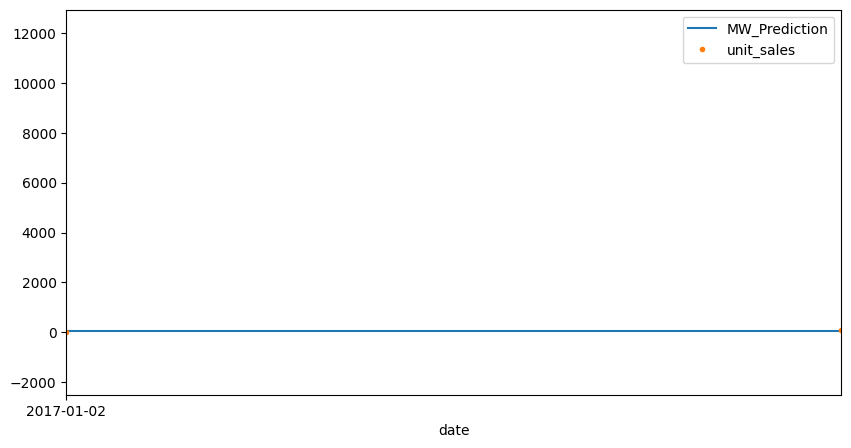

In [52]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','unit_sales']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_ylim(0, 60000)
ax.set_xbound(lower='2017-01-01', upper='2017-02-01')
# plot = plt.suptitle('Oct 3, 2016 - Дни с наилучшим предсказанием')

# Сравним с CatBoost

In [53]:
cbr = CatBoostRegressor(n_estimators=1000)
cbr.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

In [54]:
pjme_test['MW_Prediction_catboost'] = cbr.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

In [55]:
mean_squared_error(y_true=pjme_test['unit_sales'],
                   y_pred=pjme_test['MW_Prediction_catboost']), mean_absolute_error(y_true=pjme_test['unit_sales'],
                   y_pred=pjme_test['MW_Prediction_catboost'])

(1281.8824071710974, 26.654584406308608)

In [56]:
mean_absolute_percentage_error(y_true=pjme_test['unit_sales'],
                   y_pred=pjme_test['MW_Prediction_catboost'])

141.3657064554771

Ошибка не сильно отличается от результатов XGBoost, но как правило, требуется дополнительная настройка модели и добавление признаков.

# Что дальше?
- Можно добавить лаги
- Добавить праздники
- Добавить погодные условия